## Model Development

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Import clean data

df_sf = pd.read_csv('data\cleaned_data.csv')

In [5]:
# Drop the town column

df_sf = df_sf.drop(columns = {'town'})

In [6]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


# Function to evaluate the best models using RMSE and R²
def evaluate_best_models(X, y):
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'XGBoost Regressor': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    }
    
    # Dictionary to store the results
    results = {}
    
    # Define cross-validation strategy
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for name, model in models.items():
        # Perform cross-validation for RMSE
        mse = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
        rmse = np.sqrt(np.mean(mse))  # Calculate RMSE
        
        # Perform cross-validation for R²
        r2 = cross_val_score(model, X, y, scoring='r2', cv=cv).mean() 
        
        # Store the results  
        results[name] = {'RMSE': rmse, 'R²': r2}
    
    return results

X = df_sf[['sales_ratio', 'assessed_value', 'list_year']]
y = df_sf['sale_amount']

# Evaluate the best models and display results
model_performance = evaluate_best_models(X, y)
print(model_performance)


{'Linear Regression': {'RMSE': 157673.41184038663, 'R²': 0.9415514602474812}, 'Random Forest': {'RMSE': 56048.845592651924, 'R²': 0.9927576592201106}, 'Gradient Boosting': {'RMSE': 56084.59977938714, 'R²': 0.9927452674793251}, 'XGBoost Regressor': {'RMSE': 237229.94931267135, 'R²': 0.8677155534395589}}


The Random Forest Regressor emerged as the best-performing model on the dataset, achieving an R² score of 0.993 and a Root Mean Squared Error (RMSE) of $56,048.

In [7]:
# Random Forest was identified as the best performing model 
best_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the entire dataset 
best_model.fit(X, y)


RandomForestRegressor(random_state=42)

Feature Importance

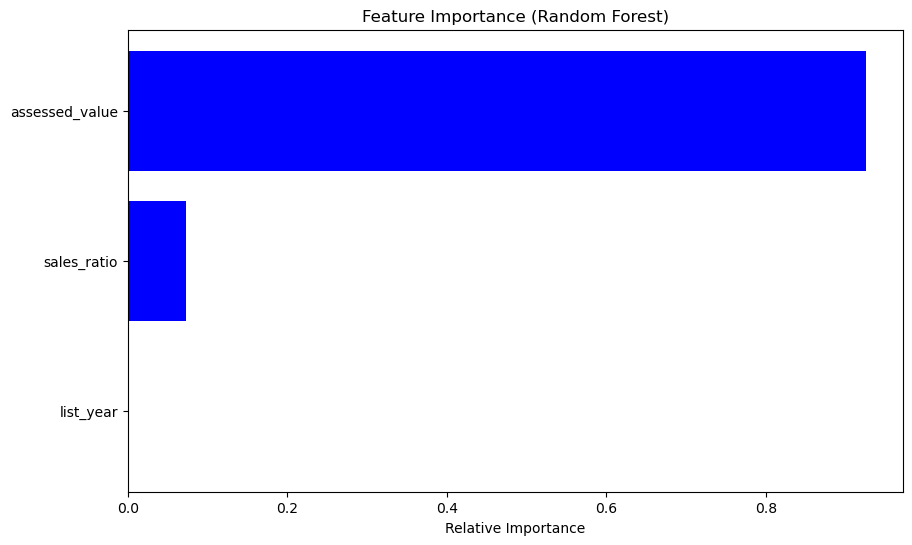

In [8]:
# Plot Feature Importance

importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.title('Feature Importance (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


Insights: 

Assessed value is by far the most important feature, driving the majority of the model’s predictions. The sales ratio plays a minor role, and list year has little to no impact. This suggests that further improvements could come from incorporating additional relevant features.

------------------------------------------------------------------------------------------------------

Predicted vs. Actual Plot

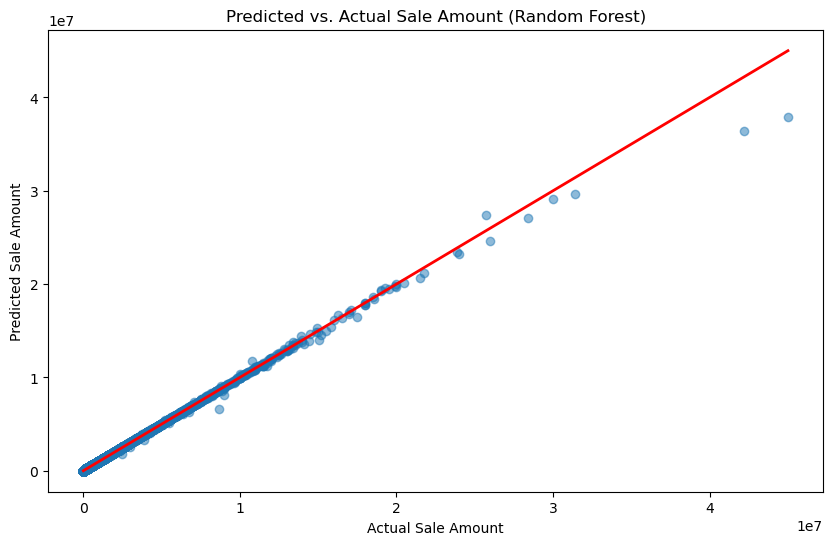

In [9]:
# Plot Predicted vs Actual Values 

y_pred = best_model.predict(X)

plt.figure(figsize=(10,6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2)
plt.xlabel('Actual Sale Amount')
plt.ylabel('Predicted Sale Amount')
plt.title('Predicted vs. Actual Sale Amount (Random Forest)')
plt.show()


Insights: 

Most predicted sale amounts closely align with the actual values, confirming the model’s accuracy. However, for very high-priced properties, predictions deviate slightly, indicating the model struggles more with luxury homes. Overall, the model performs well for the majority of the data.



------------------------------------

Error Analysis

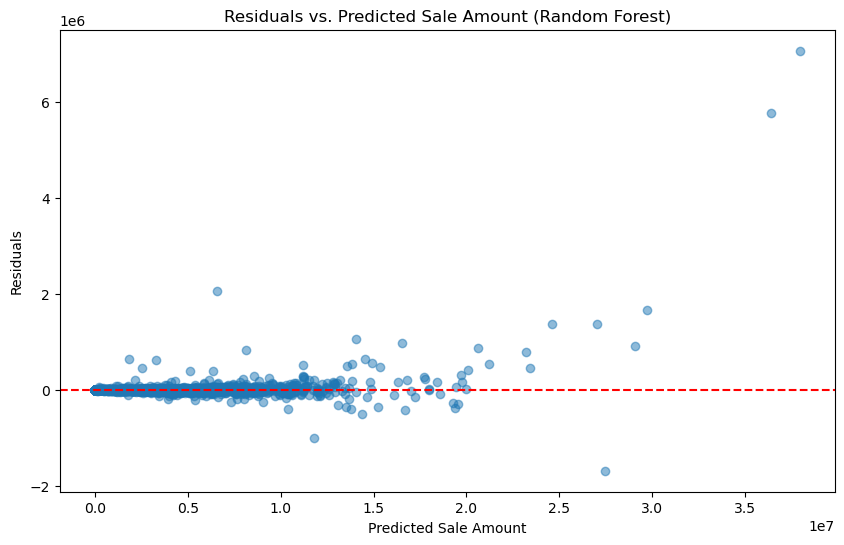

In [10]:
residuals = y - y_pred

plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Sale Amount')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Sale Amount (Random Forest)')
plt.show()


Insights: 

The residuals are mostly centered around 0, indicating good predictions for most homes. However, as sale amounts increase, the residuals spread out, meaning the model is less accurate for high-priced properties. Outliers in both directions suggest the model struggles with unique or extreme cases, particularly for luxury homes.

------------------------

Summary of Findings

- The Random Forest model performs exceptionally well in predicting sale amounts for single-family homes in Connecticut, with a high degree of accuracy for most homes.
Assessed value is the dominant feature driving the predictions, which aligns with expectations in real estate where properties are typically priced based on their assessed values.
The model struggles with luxury properties, as seen in the residual spread for high-priced homes, indicating the need for additional data or features to better capture the variability in those markets.
Model Insights:

- The model’s reliance on assessed value confirms that it's a key factor in determining the sale price. However, the relatively low importance of other features like the sales ratio and list year suggests the need for additional predictors.
The current model provides a solid foundation for estimating home sale prices, but further improvements, such as including location data or property characteristics (e.g., square footage, number of bedrooms), could refine its predictions, particularly for high-end properties.

Potential Improvements:

- Future iterations of the model could benefit from additional data that captures location, property features, and buyer preferences, especially in the luxury segment.
Addressing outliers in the high-end market by incorporating specialized data for luxury homes would further enhance prediction accuracy across all price ranges.